<a href="https://colab.research.google.com/github/ykato27/Segmentation/blob/main/CSAILVision_SemanticSegmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CSAILVision semantic segmention models

This is a semantic segmentation notebook using an [ADE20K](http://groups.csail.mit.edu/vision/datasets/ADE20K/) pretrained model from the open source project [CSAILVision/semantic-segmentation-pytorch](https://github.com/CSAILVision/semantic-segmentation-pytorch).

For other deep-learning Colab notebooks, visit [tugstugi/dl-colab-notebooks](https://github.com/tugstugi/dl-colab-notebooks).

## Clone repo and install dependencies

In [1]:
import os
from os.path import exists, join, basename, splitext

git_repo_url = 'https://github.com/CSAILVision/semantic-segmentation-pytorch.git'
project_name = splitext(basename(git_repo_url))[0]
if not exists(project_name):
  # clone and install dependencies
  !git clone -q $git_repo_url
  #!cd $project_name && pip install -q -r requirement.txt
  
import sys
sys.path.append(project_name)
import time
import matplotlib
import matplotlib.pylab as plt
plt.rcParams["axes.grid"] = False

## Download a pretrained model

According to [https://github.com/CSAILVision/semantic-segmentation-pytorch#performance](https://github.com/CSAILVision/semantic-segmentation-pytorch#performance),  **UperNet101** was the best performing model. We will use it as the pretrained model:

In [2]:
ENCODER_NAME = 'resnet101'
DECODER_NAME = 'upernet'
PRETRAINED_ENCODER_MODEL_URL = 'http://sceneparsing.csail.mit.edu/model/pytorch/ade20k-%s-%s/encoder_epoch_50.pth' % (ENCODER_NAME, DECODER_NAME)
PRETRAINED_DECODER_MODEL_URL = 'http://sceneparsing.csail.mit.edu/model/pytorch/ade20k-%s-%s/decoder_epoch_50.pth' % (ENCODER_NAME, DECODER_NAME)

pretrained_encoder_file = basename(PRETRAINED_ENCODER_MODEL_URL)
if not exists(pretrained_encoder_file):
  !wget -q $PRETRAINED_ENCODER_MODEL_URL
pretrained_decoder_file = basename(PRETRAINED_DECODER_MODEL_URL)
if not exists(pretrained_decoder_file):
  !wget -q $PRETRAINED_DECODER_MODEL_URL

## Prepare model

Load the pretrained model:

In [3]:
from types import SimpleNamespace
import torch
from mit_semseg.models import ModelBuilder, SegmentationModule
from mit_semseg.dataset import TestDataset
from mit_semseg.utils import colorEncode
from scipy.io import loadmat

# options
options = SimpleNamespace(fc_dim=2048,
                          num_class=150,
                          imgSizes = [300, 400, 500, 600],
                          imgMaxSize=1000,
                          padding_constant=8,
                          segm_downsampling_rate=8)

# create model
builder = ModelBuilder()
net_encoder = builder.build_encoder(arch=ENCODER_NAME, weights=pretrained_encoder_file,
                                    fc_dim=options.fc_dim)
net_decoder = builder.build_decoder(arch=DECODER_NAME, weights=pretrained_decoder_file,
                                    fc_dim=options.fc_dim, num_class=options.num_class, use_softmax=True)
segmentation_module = SegmentationModule(net_encoder, net_decoder, torch.nn.NLLLoss(ignore_index=-1))
segmentation_module = segmentation_module.eval()
torch.set_grad_enabled(False)

if torch.cuda.is_available():
  segmentation_module = segmentation_module.cuda()

# test on a given image
def test(test_image_name):
  dataset_test = TestDataset([{'fpath_img': test_image_name}], options, max_sample=-1)
  
  batch_data = dataset_test[0]
  segSize = (batch_data['img_ori'].shape[0], batch_data['img_ori'].shape[1])
  img_resized_list = batch_data['img_data']
  
  scores = torch.zeros(1, options.num_class, segSize[0], segSize[1])
  if torch.cuda.is_available():
    scores = scores.cuda()

  for img in img_resized_list:
    feed_dict = batch_data.copy()
    feed_dict['img_data'] = img
    del feed_dict['img_ori']
    del feed_dict['info']
    if torch.cuda.is_available():
      feed_dict = {k: o.cuda() for k, o in feed_dict.items()}

    # forward pass
    pred_tmp = segmentation_module(feed_dict, segSize=segSize)
    scores = scores + pred_tmp / len(options.imgSizes)

    _, pred = torch.max(scores, dim=1)
    return pred.squeeze(0).cpu().numpy()

Loading weights for net_encoder
Loading weights for net_decoder


## Evaluate on a test image

First, download a test image from the internet:

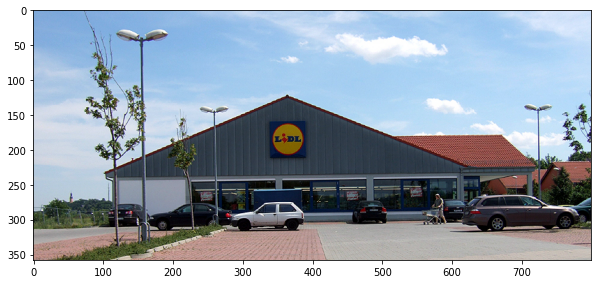

In [4]:
IMAGE_URL = 'https://raw.githubusercontent.com/tugstugi/dl-colab-notebooks/master/resources/lidl.jpg'

image_file = basename(IMAGE_URL)
!wget -q -O $image_file $IMAGE_URL

plt.figure(figsize=(10, 5))
plt.imshow(matplotlib.image.imread(image_file))

Now, test on the downloaded image:

# samples: 1


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


executed in 0.715s


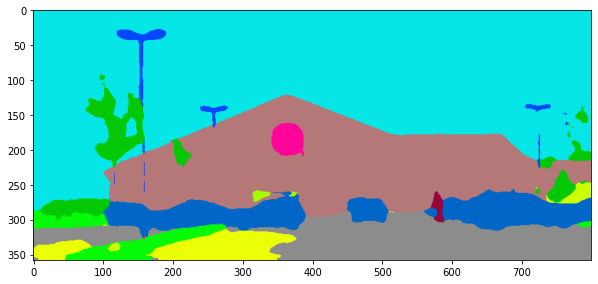

In [5]:
t = time.time()
pred = test(image_file)
print("executed in %.3fs" % (time.time()-t))

pred_color = colorEncode(pred, loadmat(os.path.join(project_name, 'data/color150.mat'))['colors'])
plt.figure(figsize=(10, 5))
plt.imshow(pred_color)